In [1]:
import sys
sys.path.append('/public/src')
from factor_evaluation_server import FactorEvaluation,DataService # type: ignore
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import pandas_ta as ta

In [2]:
ds=DataService()
df=ds['ETHUSDT_15m_2020_2025']['2021-10-01':]

In [3]:
# 添加缺失的vwap字段（如果未提供）
if 'vwap' not in df.columns:
    df['vwap'] = df['turnover'] / df['volume']

In [4]:
evaluator=FactorEvaluation(df=df,future_return_periods=10)

# 定义因子！

In [5]:
def calculate_kup1_rsi_vol(df, rsi_window=14, vol_window=5):
    """
    成交量增强的尾部信号因子
    原理：上影线短且成交量异常放大时，表明多头无力推高价格
    公式：KUP1_RSI_VOL = (high - max(open, close)) / open * rsi_divergence * vol_ratio
    """
    # 计算RSI
    df['rsi'] = ta.rsi(df['close'], length=rsi_window)
    
    # 识别超买区域（RSI>70）
    overbought = np.where(df['rsi'] > 70, 1.5, 0.5)
    
    # 基础KUP1计算
    max_open_close = np.maximum(df['open'], df['close'])
    upper_shadow = df['high'] - max_open_close
    base_kup1 = upper_shadow / df['open']
    
    # 成交量增强：计算成交量比率（当前成交量/近期平均）
    vol_ma = df['volume'].rolling(vol_window).mean()
    vol_ratio = df['volume'] / vol_ma
    
    # 尾部信号增强：上影线短且成交量放大时强化负信号
    # 当上影线处于后20%且成交量>1.5倍均量时，放大信号
    shadow_rank = base_kup1.rank(pct=True)
    vol_condition = (shadow_rank < 0.2) & (vol_ratio > 1.5)
    enhancement = np.where(vol_condition, 1.5, 1.0)
    
    return base_kup1 * overbought * enhancement * np.where(vol_condition, -1, 1)

# 因子测试

In [6]:
evaluator.set_factor(
    factor_func=calculate_kup1_rsi_vol,
    factor_name='calculate_kup1_rsi_vol'
)


📊 单币种 (single) 详细评估结果:
--------------------------------------------------
🔗 相关性分析:
   IC (Pearson): 0.011905
   Rank_IC (Spearman): 0.010140
📊 信息比率:
   IR: -0.083167
   有效分组数: 10
📊 因子分布:
📋 数据概况:
   数据长度: 130731
   因子列: calculate_kup1_rsi_vol
   收益率列: future_return
   未来收益周期: 10
--------------------------------------------------

🖼️  单币种 (single) 图片展示:
----------------------------------------
📊 显示分组分析图...


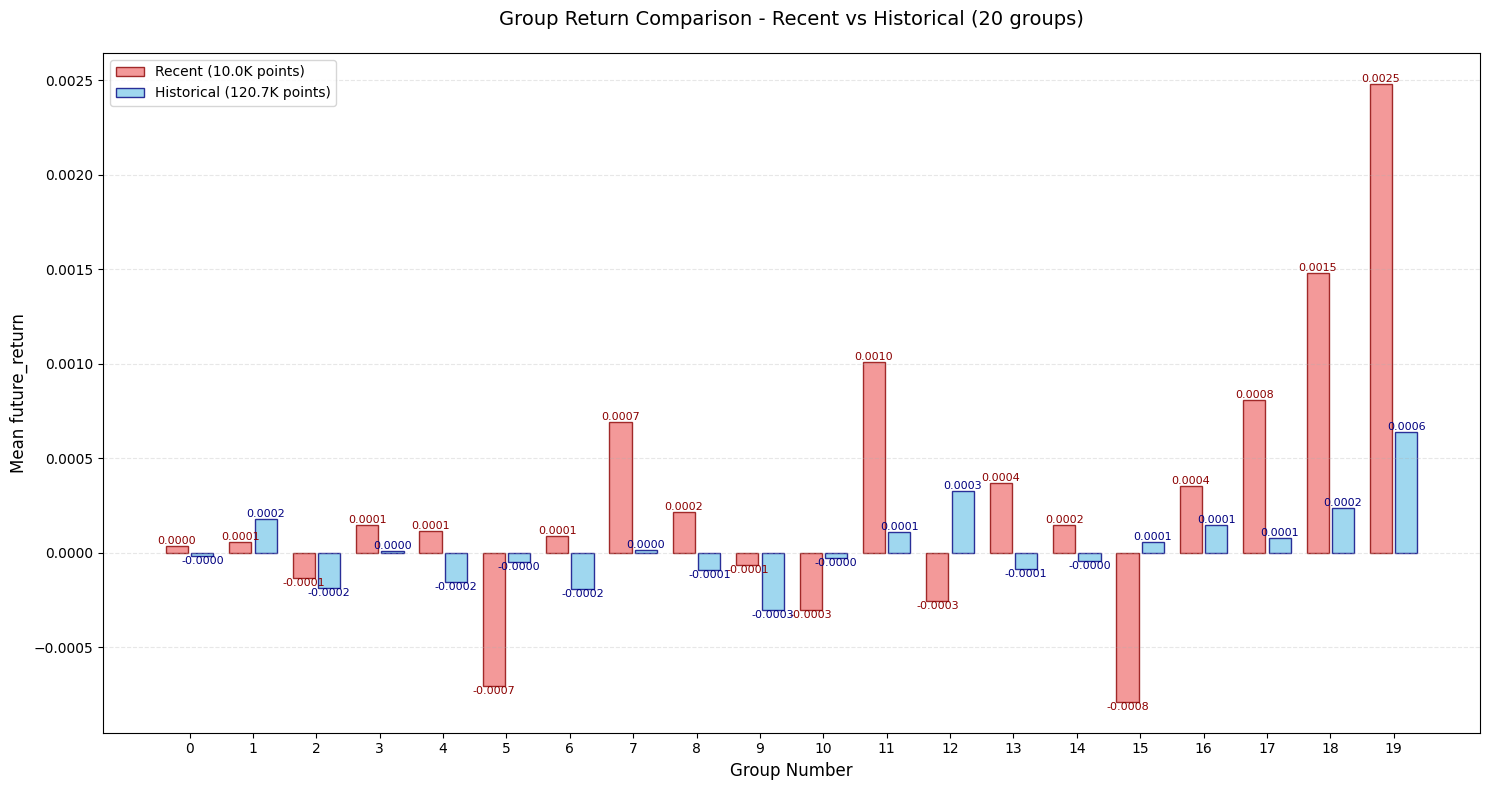

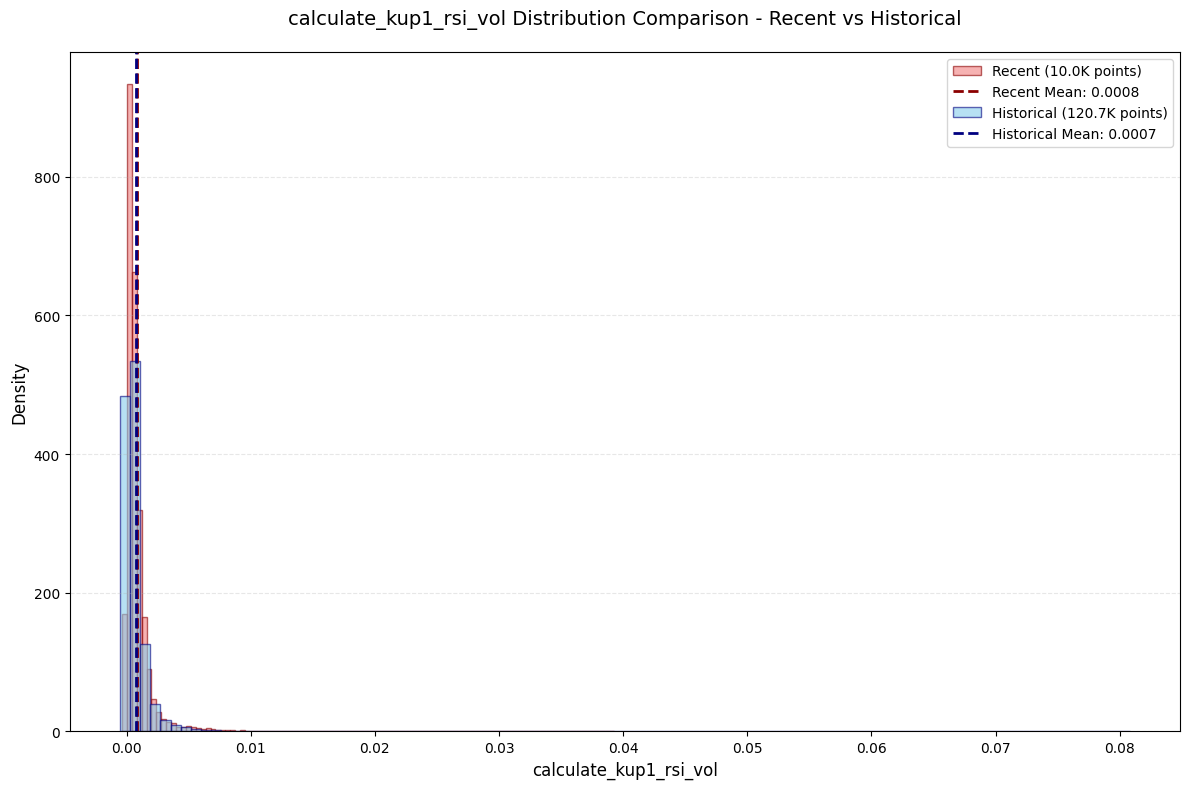

📈 显示因子分布图...
✅ 已显示 2 个图片
----------------------------------------


In [7]:
result=evaluator.run_full_evaluation(run_stationarity_test=False)